In [33]:
import xarray as xr
import matplotlib.pyplot as plt
import glob
import numpy as np
from scipy.stats import pearsonr, skew
import math
x = float('nan')
#fucntion to define DMI, ENSO index and strength
def index(DS):
    sst=xr.open_mfdataset(DS).tos
    if sst.mean() > 100:
        sst = sst-273.15  
    if sst.mean() < 0:
        sst=sst.where(sst > 0, drop = True)
    #interpolate missing vals in CMCC models
    if math.isnan(sst.sel(lat=slice(-69,11),lon=slice(72,74)).mean()) is True:
        blank=sst.where(sst>0, drop=True)#get rid of blanks section
        line = sst.interpolate_na('lon').sel(lat=slice(-69,11),lon=slice(72,74))#get line of blank data
        rolled=blank.assign_coords(lon=(blank.lon % 360)).roll(lon=106, roll_coords=True)#move the blank space to end
        alvals=xr.concat([line, rolled], dim = 'lon')#concat data
        sst=alvals.assign_coords(lon=(alvals.lon % 360)).roll(lon=-108, roll_coords=True)#back to original format
    if DS in glob.glob('../../../CMIP_TOS/CMCC*.nc'):
        blank=sst.where(sst>0, drop=True)#get rid of blanks section
        line = sst.interpolate_na('lon').sel(lat=slice(-69,11),lon=slice(78,80))#get line of blank data
        rolled=blank.assign_coords(lon=(blank.lon % 360)).roll(lon=100, roll_coords=True)#move the blank space to end
        alvals=xr.concat([line, rolled], dim = 'lon')#concat data
        sst=alvals.assign_coords(lon=(alvals.lon % 360)).roll(lon=-102, roll_coords=True)#back to original format
    sst=sst.assign_coords(lon=(sst.lon % 360)).roll(lon=180, roll_coords=True)#get so 180 is central longitude
    sst = sst.sel(lat=slice(-30,30),lon=slice(40,290))
    climatology_mean=sst.groupby('time.month').mean('time')
    ssta=sst.groupby('time.month')-climatology_mean
    #detrend data with globally averaged sst
    sstade=ssta.chunk((132, 60, 250)).rolling(time=264,center=True)
    sstade_TS=sstade.mean()#this timeseries is detreneded at every point individually
    # remove years with nan
    sstade_nan=sstade_TS.dropna('time',how='all')#this gets rid of all the years with nan ie the years consumed in the rolling average
    ssta=ssta-sstade_nan
    WTIO=ssta.sel(lat=slice(-10,10),lon=slice(50,70)).mean(['lat','lon'])
    SETIO=ssta.sel(lat=slice(-10,0),lon=slice(90,110)).mean(['lat','lon'])
    DMI=WTIO-SETIO
    Dstd=DMI.groupby('time.month').std(dim=('time'), keep_attrs=True).sel(month=slice(9,11)).mean()
    Nino34=ssta.sel(lat=slice(-5,5),lon=slice(190,240)).mean(['lat','lon'])
    Nino3=ssta.sel(lat=slice(-5,5),lon=slice(210,270)).mean(['lat','lon'])
    Nino4=ssta.sel(lat=slice(-5,5),lon=slice(160,210)).mean(['lat','lon'])

    NstdJF =  Nino34.groupby('time.month').std(dim=('time'), keep_attrs=True).sel(month=slice(1,2)).mean()
    NstdD =  Nino34.groupby('time.month').std(dim=('time'), keep_attrs=True)[11]
    Nstd = (NstdD+(2*NstdJF))/3
    return (DMI, Nino34, Nino3, Nino4)


In [34]:
DMI, Nino34, Nino3, Nino4 = index('/g/data/e14/sm2435/CMIP6/EC-Earth3/TOS/*.nc')

/apps/jupyterlab/2.1.4-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  # Remove the CWD from sys.path while we load stuff.
/apps/xarray/0.15.1-py3.7/lib/python3.7/site-packages/xarray-0.15.1-py3.7.egg/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/apps/python3/3.7.4/lib/python

In [4]:
SST = xr.open_mfdataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/TOS/*.nc').tos

/apps/jupyterlab/2.1.4-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/apps/xarray/0.15.1-py3.7/lib/python3.7/site-packages/xarray-0.15.1-py3.7.egg/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


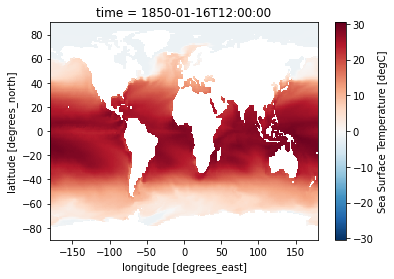

In [6]:
SST[0].plot()

In [36]:
DMI

,Array,Chunk
Bytes,6.87 kB,4 B
Shape,"(1717,)","(1,)"
Count,31454 Tasks,1717 Chunks
Type,float32,numpy.ndarray


/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


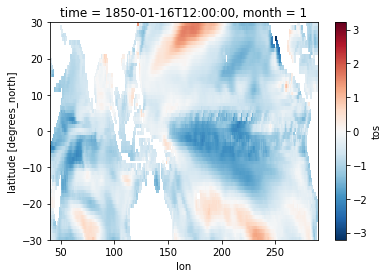

In [12]:
ssta[0].plot()

In [29]:
ssta

,Array,Chunk
Bytes,118.80 MB,60.00 kB
Shape,"(1980, 60, 250)","(1, 60, 250)"
Count,12105 Tasks,1980 Chunks
Type,float32,numpy.ndarray


In [32]:
ssta.chunk((132, 60, 250)).rolling(time = 260).mean()

<xarray.DataArray (time: 1980, lat: 60, lon: 250)>
dask.array<where, shape=(1980, 60, 250), dtype=float32, chunksize=(132, 60, 250), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
  * lon      (lon) float64 40.5 41.5 42.5 43.5 44.5 ... 286.5 287.5 288.5 289.5
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
    month    (time) int64 dask.array<chunksize=(132,), meta=np.ndarray>

In [39]:
DMIsd = DMI.groupby('time.month').std(dim=('time'), keep_attrs=True)

/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide

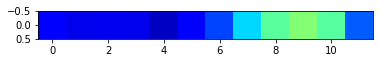

In [40]:
plt.imshow([DMIsd], vmin=0.204, vmax=2.02, cmap = 'jet')

In [41]:
from scipy.stats import pearsonr, skew
DMI_SK = skew(DMI)

/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [42]:
DMI_SK

0.53046715259552

In [45]:
print(DMI.std().values)

/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.68534607


/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide

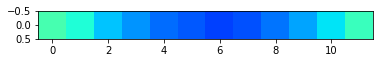

In [47]:
 plt.imshow([Nino34.groupby('time.month').std(dim=('time'), keep_attrs=True)], vmin=0.204, vmax=2.02, cmap = 'jet')#common colorscale on all subplots

In [49]:
Nino_SK = skew(Nino3)
print(Nino_SK)

/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.2922813594341278
